- [Download dataset](#download_dataset)
- [Prepare train and test sets](#prepare_datasets)
- [Dumb classifier!!!](#dumb_clf)
- [Binary classifier - SGD Classifier](#sgd_clf)
- [Confusion matrix](#confmat)
- [How to use cross-validation and confusion matrix simultaneously](#confmat_cv)
- [More concise metrics](#metrics)
- [Example: Comparing different models and choosing the best one](#example_best_model)
- [Precision/Recall Tradeoff](#pr_tradeoff)
- [Precision/Recall Curve](#pr_curve)
- [ROC curve](#roc_curve)

# Download dataset<a name = 'download_dataset'></a>

In [1]:
from sklearn.datasets import fetch_openml

# a workaround to avoid multiple downloads of the dataset.
from joblib import Memory
memory = Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

# Load data from https://www.openml.org/d/554
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html
X, y = fetch_openml_cached('mnist_784', version=1, return_X_y=True, data_home = '../DATASETS') # it takes time! - Downloads everytime!

In [2]:
print(type(y))
print(type(y.values))
print(type(y[0]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.arrays.categorical.Categorical'>
<class 'str'>


In [3]:
import numpy as np

y = np.int32(y)

# Prepare train and test sets<a name=  'prepare_datasets'></a>

In [4]:
import numpy as np

N = 60000

X_train = np.float64(X[:N]) # np.float64 is used to avoid warnings when preprocessing data
y_train = y[:N]

X_test = np.float64(X[N:])
y_test = y[N:]

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Dumb classifier!!<a name = 'dumb_clf'></a>

In [6]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class dumbClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
dumb_clf = dumbClassifier()

dumb_clf.fit(X_train, y_train_5)

In [7]:
accuracy_score(y_train_5, dumb_clf.predict(X_train))

0.90965

# Binary classifier - SGD Classifier <a name = 'sgd_clf'></a>

In [17]:
import time

from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

model = Pipeline([('scaler', StandardScaler()), 
                  ('sgd_clf', SGDClassifier(random_state=0, loss = 'log',alpha = 0.00001, max_iter=5, tol = None, learning_rate = 'optimal'))]) 

start_time = time.time()

model.fit(X_train, y_train_5)

print("Elapsed time %.2f seconds." % (time.time() - start_time))

Elapsed time 1.94 seconds.


In [18]:
model.score(X_train,y_train_5) 

0.9738333333333333

# Confusion matrix<a name = 'confmat'></a>

`confusion_matrix(y_true, y_pred,...)`

In [19]:
from sklearn.metrics import confusion_matrix

confm_dumb = confusion_matrix(y_train_5, dumb_clf.predict(X_train))
confm_model = confusion_matrix(y_train_5, model.predict(X_train))

print(confm_dumb)
print('')
print(confm_model)

[[54579     0]
 [ 5421     0]]

[[54055   524]
 [ 1046  4375]]


In [20]:
tp = 4375
total = 54055 + 524 + 1046 + 4375

tp/total

0.07291666666666667

In [21]:
tp / (5421)

0.8070466703560228

## Plot the confusion matrix

You can also plot the confusion matrix in a more interesting way:

See [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)


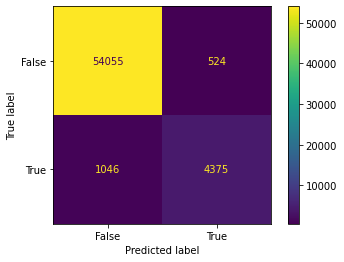

In [11]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_train, y_train_5)  # model.predict(..)

plt.show() 

Instead of counts, it may prefer to use rates. E.g., instead of TP, we may prefer to report True Positive Rate (TPR).

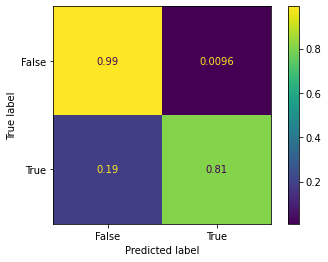

In [12]:
plot_confusion_matrix(model, X_train, y_train_5, normalize ='true')  

plt.show() 


Unfortunately, the above function requires the estimator/model. 

In [27]:
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_ma(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

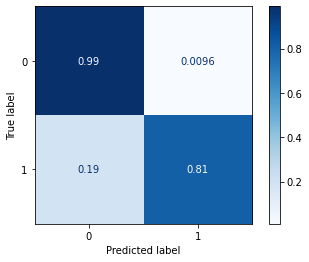

In [28]:
confusion_ma(y_train_5, model.predict(X_train),None)

# How to use cross-validation and confusion matrix simultaneously <a name = 'confmat_cv'></a>

Basically, you need to have a set of predictions and compare them to the actual targets to compute confusion matrix.

Remember, do not touch the test set until the end of your project. 

Prediction on the training set may not be a good representative of the model's generalization error. 

We can use CROSS VALIDATION - but `cross_val_score` only computes a set of scores - How can we obtain predictions?

Just like the `cross_val_score()`, the `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(model, X_train, y_train_5, cv=3)

In [31]:
y_train_pred.shape

(60000,)

Why it does not return three predicions for each sample?!! See [here](https://stackoverflow.com/questions/41458834/how-is-scikit-learn-cross-val-predict-accuracy-score-calculated)

>The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

In [32]:
accuracy_score(y_train_5, y_train_pred)

0.9695833333333334

In [33]:
confm_model = confusion_matrix(y_train_5, y_train_pred)

print(confm_model)

[[53874   705]
 [ 1120  4301]]


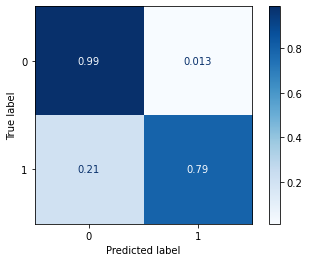

In [34]:
confusion_ma(y_train_5, y_train_pred,None)

# More concise metrics<a name = 'metrics'></a>

Confusion matrix has lots of information. 

How to summarize information given by confusion matrix?

## Precision: The accuracy of positive predictions

$\text{precision} = \frac{TP}{TP + FP}$

## Recall / TPR / Sensetivity = The ratio of positive instances that are detected by the classifier

$recall = \frac{TP}{TP + FN}$

The difference between precision and recall are in their denominators

The following figure show how these metrics can be computed from a confusion matrix of a 5-image recognizer:

In [19]:
from IPython.display import Image
Image(url= "./confusion_matrix_illustrated.png", width=800, height=450)

Increasing FPs, leads to lower precision<br>
Increasing FNs, leads to lower recall

## Compute Precision and Recall

In [20]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [21]:
y_pred_model = model.predict(X_train);

confusion_matrix(y_train_5, y_pred_model)

array([[54055,   524],
       [ 1046,  4375]], dtype=int64)

In [22]:
print('PR = %0.3f'% precision_score(y_train_5, y_pred_model))
print('Recall = %0.3f'% recall_score(y_train_5, y_pred_model))

PR = 0.893
Recall = 0.807


When your classifier claims an image is 5, it is correct only 89 percent of the times. Also, it only classifies 81 percent of the 5 images in the training set.

Let's compute precision and recall for the dumb classifier

In [23]:
y_pred_dumb = dumb_clf.predict(X_train);

confusion_matrix(y_train_5, y_pred_dumb)

array([[54579,     0],
       [ 5421,     0]], dtype=int64)

In [24]:
print('PR = %0.3f'% precision_score(y_train_5, y_pred_dumb))
print('Recall = %0.3f'% recall_score(y_train_5, y_pred_dumb))

PR = 0.000
Recall = 0.000


C:\Users\ashkan\Anaconda3\envs\py36tf18-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## $\text{F}_1$ score

This score combines both precision and recall using the harmonic mean of them.

$\text{F}_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}} = 2 \times \frac{\text{precision}\times \text{recall}}{\text{precision}+\text{recall}}$

In [25]:
from sklearn.metrics import f1_score

f1_dumb = f1_score(y_train_5, y_pred_dumb)
f1_model = f1_score(y_train_5, y_pred_model)

print('f1 for dumb =%0.3f'%f1_dumb)
print('f1 for model =%0.3f'%f1_model)

f1 for dumb =0.000
f1 for model =0.848


In [37]:
2/np.inf

0.0

**Why harmonic mean is used to combine both metrics?**

The regular mean treats all values equally, the harmonic mean gives much more weight to low values. 

F1 score is high whenever both recall and precision are hight.

# Example: Comparing different models and choosing the best one. <a name = 'example_best_model'></a>

There are lots of functions for preprocessing data. You can see (here)[https://scikit-learn.org/stable/modules/preprocessing.html]. Select the one which is suitable for your data.

In [38]:
from sklearn.linear_model import SGDClassifier

from sklearn.base import clone # Constructs a new unfitted estimator with the same parameters.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

Define multiple models

In [39]:
model1 = SGDClassifier(random_state=0, loss = 'log', max_iter=5, tol = None, alpha=0.001)

model2 = Pipeline([('scaler', StandardScaler()), 
                  ('sgd_clf', clone(model1))])  

model3 = Pipeline([('minmax', MinMaxScaler()),
                   ('sgd_clf', clone(model1))])

model4 = Pipeline([('yao', QuantileTransformer(output_distribution='normal', random_state=0)),
                   ('sgd_clf', clone(model1))]) # Gaussinization Transform

If you want to create a custom Transformer that can be used with a Pipline in Scicit-Learn, see [here](https://github.com/HCGrit/MachineLearning-iamJustAStudent/tree/master/PipelineFoundation)

Perform cross-validation to find the best model (e.g., in terms of f1 score)

In [40]:
y_train_pred_model1 = cross_val_predict(model1, X_train, y_train_5, cv = 3)
y_train_pred_model2 = cross_val_predict(model2, X_train, y_train_5, cv = 3)
y_train_pred_model3 = cross_val_predict(model3, X_train, y_train_5, cv = 3)
y_train_pred_model4 = cross_val_predict(model4, X_train, y_train_5, cv = 3)
y_train_pred_model5 = cross_val_predict(model1, X_train / 255.0, y_train_5, cv = 3)

In [41]:
f1_model1 = f1_score(y_train_5, y_train_pred_model1)
f1_model2 = f1_score(y_train_5, y_train_pred_model2)
f1_model3 = f1_score(y_train_5, y_train_pred_model3)
f1_model4 = f1_score(y_train_5, y_train_pred_model4)
f1_model5 = f1_score(y_train_5, y_train_pred_model5)

print('F1 for model1 =%0.3f'%f1_model1)
print('F1 for model2 =%0.3f'%f1_model2)
print('F1 for model3 =%0.3f'%f1_model3)
print('F1 for model4 =%0.3f'%f1_model4)
print('F1 for model4 =%0.3f'%f1_model5)

F1 for model1 =0.749
F1 for model2 =0.770
F1 for model3 =0.819
F1 for model4 =0.692
F1 for model4 =0.819


In [42]:
print(accuracy_score(y_train_5,y_train_pred_model1))
print(accuracy_score(y_train_5,y_train_pred_model2))
print(accuracy_score(y_train_5,y_train_pred_model3))
print(accuracy_score(y_train_5,y_train_pred_model4))
print(accuracy_score(y_train_5,y_train_pred_model5))

0.9534833333333333
0.96285
0.9700333333333333
0.9390666666666667
0.9700166666666666


Let's pick the model with the highest *metric* and train it. Then, report the final result over test dataset:

In [43]:
model = model3
model.fit(X_train, y_train_5)

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('sgd_clf',
                 SGDClassifier(alpha=0.001, loss='log', max_iter=5,
                               random_state=0, tol=None))])

In [44]:
from sklearn.metrics import accuracy_score

y_test_pred = model.predict(X_test)

print('Metric results of the selected model for the TEST set:')
print('Accuracy = %0.3f'%accuracy_score(y_test_5,y_test_pred))
print('F1 score = %0.3f'%f1_score(y_test_5, y_test_pred))

Metric results of the selected model for the TEST set:
Accuracy = 0.974
F1 score = 0.841


Since the accuracy of train and test are very close to each other. There might be a risk of underfitting. So, we can have a more relax model by decreasing the reguralization strength (e.g., use alpha = 0.00001). However, in this case, it does not improve the performance.

# Precision/Recall Tradeoff<a name = 'pr_tradeoff'></a>

- Safe Video Detection: 

bad(-), good(+) => we do not want to have lots of bad videos detected as good! => low # of FPs is prefered => high precision is favored.

- Shoplifter Detector on Surverillance Camera: 

shoplifter(+), normal customer(-) => we do not want a thieft to be detected as normal => low # of FNs is prefered => high recall

**Increasing precision, reduces recall, and vice versa.**

How SGDClassifier makes its classification decisions?

For each instance, it computes a score based on a decision function.

If the score is greater than a threshold, it assigns that instance to the + class.

In [33]:
from IPython.display import Image
Image(url= "./precision_recall_tradeoff_1.png")

Scikit-Learn does not let you set the threshold directly.

Instead, you can access to the decision scores.

Call `decision_function` instead of `predict`.

In SGDClassifier, default threshold is 0. However, note that when you use logistic loss it is different.

## How does decision made for an example?

In [45]:
ind_5 = np.where(y_train == 5)
print(ind_5)

(array([    0,    11,    35, ..., 59968, 59993, 59997], dtype=int64),)


label: 3


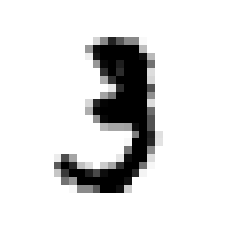

In [47]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

ii = 10
sample = X_train[ii]
sample_img = sample.reshape(28, 28)

plt.imshow(sample_img, 
           cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

print('label: %s'%y[ii]) # Note that the labels are stored as string!
plt.show()

`model.predict` - `model.predict_proba` - `model.decision_function` 

Note: `predict_proba` only works for classifiers with probability interpretation:<br>
Log Reg `predict_proba`

Perceptron

SGDclassifier if loss = `log` 

In [48]:
sample_vec = np.c_[sample]

print('Predicted label: ',model.predict(sample_vec.T))
print('Probabilities for each class [-,+]:', model.predict_proba(sample_vec.T))

Predicted label:  [False]
Probabilities for each class [-,+]: [[0.99765286 0.00234714]]


In [49]:
score_ = model.decision_function(sample_vec.T)
print(score_)

[-6.0522091]


Logistic Regression makes decision based on sigmoid function

In [50]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
    

sigmoid(score_)

array([0.00234714])

It uses P>=0.5 for binary classification

**Exercise**: Use `predict_proba` function in a loop with various threshold values and compute the accuracy of the model.

# Precision/Recall Curve <a name = 'pr_curve'></a>

In [51]:
y_scores = cross_val_predict(model, X_train, y_train_5, cv=3)

The above, it returns the classes associated with each training sample.

CV
model.predict(sample)

model.decision_function(sample)

In [39]:
y_scores = cross_val_predict(model, X_train, y_train_5, cv=3, method="decision_function")

In [40]:
y_scores[:15]

array([ 0.57119033, -5.66673977, -7.43124087, -5.11804983, -6.8074978 ,
       -6.15407598, -6.21018796, -6.62209107, -3.69314617, -3.0659644 ,
       -6.28907996,  1.54618106, -4.52383636, -6.21346504, -3.37488351])

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [42]:
print(thresholds.shape)
print(thresholds[0:10])
print(thresholds.min(), thresholds.max())
print(y_scores.min(), y_scores.max())

(58626,)
[-13.01528959 -13.0141855  -13.01146603 -13.00942729 -13.00838474
 -13.00835293 -13.00638111 -13.00635955 -13.00328059 -13.00208324]
-13.015289594690602 8.650316108039728
-27.099596421986977 8.650316108039728


In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

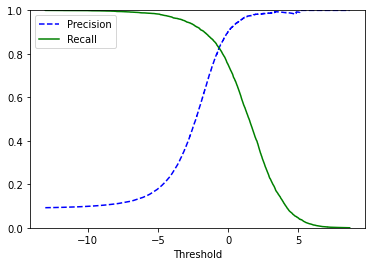

In [44]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

We can use the above plot for choosing an appropriate threshold.

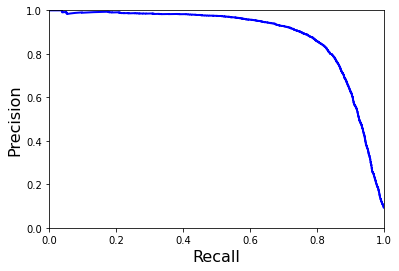

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)

# ROC curve <a name = 'roc_curve'></a>

In [47]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(model, X_train, y_train_5, cv=3, method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

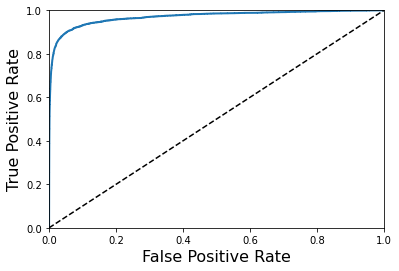

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plot_roc_curve(fpr, tpr)
plt.show()

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9701097795218113

### Try a more powerful classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state = 0)

y_probas_forest = cross_val_predict(rf_model, X_train, y_train_5, cv=3, method="predict_proba")

In [51]:
y_probas_forest.shape

(60000, 2)

The predicted class of an input sample is a vote by the trees in the forest, weighted by their probability estimates. That is, the predicted class is the one with highest mean probability estimate across the trees.

In [53]:
y_probas_forest[0:5,:]
# class 0, class 1

array([[0.18, 0.82],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [1.  , 0.  ]])

In [54]:
y_train_5[:5]

array([ True, False, False, False, False])

In [55]:
y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

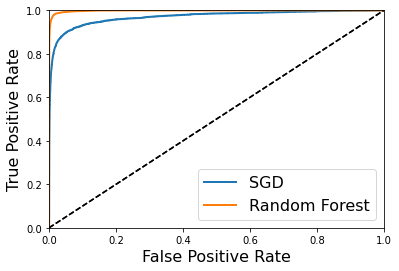

In [60]:
plot_roc_curve(fpr, tpr, label="SGD")

plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")

plt.legend(loc="lower right", fontsize=16)

In [62]:
print("AUC for SGD = ", roc_auc_score(y_train_5, y_scores))
print("AUC for Random Forest = ", roc_auc_score(y_train_5, y_scores_forest))

AUC for SGD =  0.9701097795218113
AUC for Random Forest =  0.9983139390673001


### ROC curve for the Dumb classifier

Let's see the dumb classifier!

In [69]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class dumbClassifier(BaseEstimator):
    
    def fit(self, X, y=None):
        self.classes_ = np.array([False,  True])    # --- NEW ---
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    def decision_function(self, X):                 # --- NEW ---
        tmp = np.zeros((X.shape[0], 2))
        tmp[:,0] = 1
        return tmp
    
dumb_clf = dumbClassifier()

dumb_clf.fit(X_train, y_train_5)

y_scores_dumb = cross_val_predict(dumb_clf, X_train, y_train_5, cv=3, method="decision_function")

In [71]:
y_scores_dumb = y_scores_dumb[:, 1] # score = probability of positive class

fpr_dumb, tpr_dumb, thresholds_dumb = roc_curve(y_train_5,y_scores_dumb)

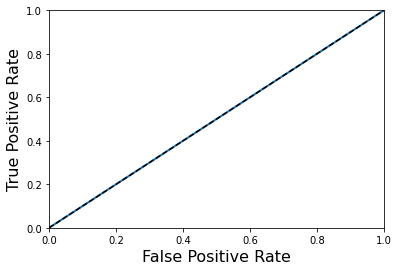

In [72]:
plot_roc_curve(fpr_dumb, tpr_dumb, label="Dumb Classifier")

In [73]:
print("AUC for dumb classifier = ", roc_auc_score(y_train_5, y_scores_dumb))

AUC for dumb classifier =  0.5


# More ...

**Excersise: Question 1 and 2, Chapter 3 - An MNIST Classifier With Over 97% Accuracy**